# Introduction to Computer Vision Using PyTorch
# Unit 5: Pre-Trained Models and Transfer Learning

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we a neural network trained on one dataset and adapt it to classifyling different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

from pytorchcv import train, plot_results, display_dataset, train_long

## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time!):

In [2]:
!wget -P data -q http://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [3]:
import zipfile
with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

Next, let's load the images into PyTorch dataset, convering them to tensors and doing some normalization. We will apply `std_normalize` transform to bring images to the range expected by pre-trained VGG network:

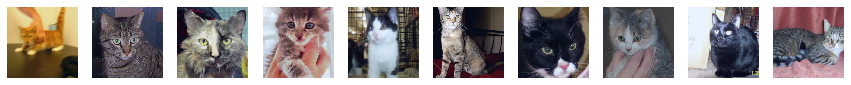

In [2]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,5000])

display_dataset(dataset)

## Pre-Trained Models

There are many different pre-trianed models available inside `torchvision` module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:

In [3]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(282)


The result that we have received is a number of an ImageNet class, which can be looked up [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can use the following code to automatically load this class table and return the result:

In [4]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

Let's also see the architecture of the VGG-16 network:

In [5]:
summary(vgg,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In addition to the layer we already know, there is also another layer type called **Dropout**. Those layers act as **regularization** technique. The way they work is during training some proportion (aroung 30%) of the neurons in the previous layer is discarded, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between different neural paths, which imporoves overall stability of the network.

## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

torch.Size([1, 512, 7, 7])


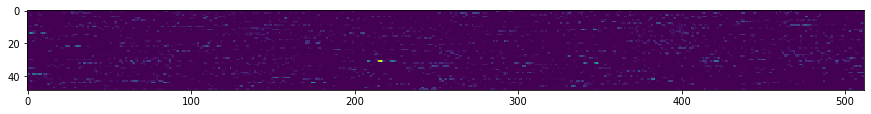

In [6]:
res = vgg.features(sample_image)
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

In [23]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7)
label_tensor = torch.zeros(num)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x)
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break


....................................................................................................

Now we can define `vgg_dataset` that takes data from this tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

In [32]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax())

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.921, Val acc=0.990, Train loss=0.047, Val loss=0.026
Epoch  1, Train acc=0.986, Val acc=0.970, Train loss=0.015, Val loss=0.047
Epoch  2, Train acc=0.999, Val acc=0.980, Train loss=0.000, Val loss=0.035
Epoch  3, Train acc=0.999, Val acc=0.970, Train loss=0.000, Val loss=0.048
Epoch  4, Train acc=1.000, Val acc=0.970, Train loss=0.000, Val loss=0.052
Epoch  5, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.040
Epoch  6, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.039
Epoch  7, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.039
Epoch  8, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.039
Epoch  9, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.039


The result is great, we can distinguish between a cat and a dog with almost 98% probability! However, we have only tested this approach on a small subset of all images, because manual feature extraction seems to take a lot of time.

## Transfer Learning using One VGG Network

We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

In [47]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

You can see that the network contains:
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset, we need to:
* **replace the final classifier** with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* **freeze weights of convolutional feature extractor**, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters to `False`

In [7]:
vgg.classifier = torch.nn.Linear(25088,2)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,input_size=(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

As you can see from the summary, this model contain aroing 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now let's train the model using our original dataset. This process will take a long time, so we will use `train_long` function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!

In [10]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,5000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1)

Epoch 0, minibatch 0: train acc = 0.5625, train loss = 0.06118020787835121
Epoch 0, minibatch 10: train acc = 0.9090909090909091, train loss = 0.06312555616552179
Epoch 0, minibatch 20: train acc = 0.9255952380952381, train loss = 0.12875109627133324
Epoch 0, minibatch 30: train acc = 0.9314516129032258, train loss = 0.1482209236391129
Epoch 0, minibatch 40: train acc = 0.9359756097560976, train loss = 0.1395893213225574


KeyboardInterrupt: 

## Takeaway

Using transfer learning, we were able to quickly put together a classifier for our custom object classification task, and chieve pretty high accuracy. However, this example was not completely fair, because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy on more exotic domain-specific objects, such as details on production line in a plant, or different tree leaves.

You can see that more complex tasks that we are solving now require higher computational power, and cannot be easily solved on the CPU. In the next unit, we will try to use more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy. 